In [1]:
!pip install transformers
!python3 -m nltk.downloader stopwords
!pip install wandb

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.7 MB/s eta 0:00:00


In [ ]:
import wandb
from wandb.keras import WandbCallback
# Login to W&B
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
from random import choice
from array import array
from nltk.tokenize.toktok import ToktokTokenizer
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re,string,unicodedata
from bs4 import BeautifulSoup
from keras.models import load_model
from tabulate import tabulate


In [ ]:

label

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/hw 2/drugsComTest_raw.tsv', sep='\t')
review = dataset.review
label =[]
for  i in range(len(dataset)):
  if dataset.rating[i]<4:
    label.append(1)
  elif dataset.rating[i]>7:
    label.append(3)
  else:
    label.append(2)
df = pd.DataFrame({0:review})
df[1] = label
df

,0,1
0,"""I&#039;ve tried a few antidepressants over th...",3
1,"""My son has Crohn&#039;s disease and has done ...",3
2,"""Quick reduction of symptoms""",3
3,"""Contrave combines drugs that were used for al...",3
4,"""I have been on this birth control for one cyc...",3
...,...,...
53761,"""I have taken Tamoxifen for 5 years. Side effe...",3
53762,"""I&#039;ve been taking Lexapro (escitaploprgra...",3
53763,"""I&#039;m married, 34 years old and I have no ...",3
53764,"""I was prescribed Nucynta for severe neck/shou...",1


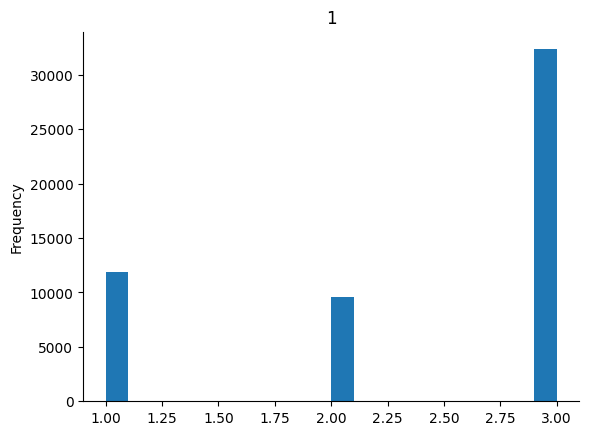

In [ ]:
from matplotlib import pyplot as plt
df[1].plot(kind='hist', bins=20, title=1)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [ ]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df[0]=df[0].apply(denoise_text)

In [ ]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
df[0]=df[0].apply(remove_special_characters)

In [ ]:

model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
tokenized = df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
# We can use max_length=128

Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


In [ ]:

labels1 = []
data = []
count = 0
limitOfEachClass = [1300,1300,1301]
for i in tokenized.values:
  if len(i) <= 128:
    if limitOfEachClass[df[1][count]-1]>0:
      data.append(i)
      labels1.append(df[1][count])
      limitOfEachClass[df[1][count]-1] = limitOfEachClass[df[1][count]-1]-1
  count += 1

tk = pd.Series(data)


In [ ]:
mean_len = 0
max_len = 0
for i in tk.values:
  mean_len += len(i)
  if len(i) > max_len:
    max_len = len(i)
padded = np.array([i + [0]*(max_len-len(i)) for i in tk.values])

attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(3901, 128)

In [ ]:
k =  500;
attention_mask = np.where(padded[0:k] != 0, 1, 0)
input_ids = torch.tensor(padded[0:k])
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
features = last_hidden_states[0].numpy()

for i in range(int(len(padded)/k)):
  attention_mask = np.where(padded[(i+1)*k:(i+2)*k] != 0, 1, 0)
  input_ids = torch.tensor(padded[(i+1)*k:(i+2)*k])
  attention_mask = torch.tensor(attention_mask)

  with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
  features= np.concatenate((features,last_hidden_states[0].numpy()))
  print(i)


0
1
2
3
4
5
6


In [ ]:
labels = pd.Series(labels1)
T=[]
for i in range(len(labels)):
  code = 'target = ['
  temp_code = 'labels[i],'
  for j in range(len(np.array(padded)[0])-1):
    code = code + temp_code
  code = code + 'labels[i]]'
  exec(code)
  T.append(target)

Y = np.array(T)

In [ ]:
#from array import array
Y = c(T)

In [ ]:
np.save('/content/drive/MyDrive/rnn/3Classfeatures3.npy', features)
np.save('/content/drive/MyDrive/rnn/3ClassY3.npy', Y)

In [ ]:
X =  np.load('/content/drive/MyDrive/rnn/3Classfeatures3.npy')
LB = np.load('/content/drive/MyDrive/rnn/3ClassY3.npy')

In [ ]:
label = []
for i in range(len(LB)):
  temp = []
  for j in range(len(LB[i])):
    temp.append(int((LB[i][j]/5)*10 - 1)/10)
  label.append(temp)
Y = np.asarray(label)

Y = LB

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(X, Y,shuffle=True)

In [ ]:
configs = dict(
    data_flag = '3Class_BERT_LSTM',
    epochs = 20,
    init_learning_rate = 0.001,
    lr_decay_rate = 0.1,
    optimizer = 'adam',
    loss_fn = 'mean_squared_error',
    metrics = ['acc','loss'],
    batch_size = 16,
    run = 10
)
#rangeOflabels = [0.1, 0.3, 0.5, 0.7, 0.9]
rangeOflabels = [1,2,3]
classLen = len(rangeOflabels)

In [ ]:

from keras.activations import softmax
#Create model MTM LSTM
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import TimeDistributed
from keras.layers import SimpleRNN
from keras.layers import RepeatVector
from keras.layers import Softmax
def creatModel():
  n_features = 768
  model = Sequential()
  model.add(LSTM(train_features.shape[1], input_shape=(train_features.shape[1], n_features),return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(train_features.shape[1], return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(train_features.shape[1], return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(train_features.shape[1], return_sequences=True))
  model.add(Dropout(0.5))
  model.add(Dense(1,activation='linear'))
  model.compile(optimizer=configs['optimizer'], loss=configs['loss_fn'])
  return model


In [ ]:
def makeTable(table):
  prec = []
  for i in range(table.shape[0]):
    temp1 = []
    for j in range(table.shape[1]):
      temp2 = []
      for k in range(len(rangeOflabels)):
        temp2.append(abs(rangeOflabels[k] - table[i][j][0]))
      temp1.append(temp2)
    prec.append(temp1)
  return prec


In [ ]:
def createTable():
  template = model.predict(train_features)
  tempTemplate = []
  for i in range(classLen):
    tempTemplate.append([])
  numOfEachTemplate = []
  for i in range(classLen):
    numOfEachTemplate.append(100)
  sequence = [i for i in range(template.shape[0])]
  i=0
  allTemplateCounter = 0
  for j in range(classLen):
    allTemplateCounter = numOfEachTemplate[j] +allTemplateCounter
  while i <allTemplateCounter:
    temp = choice(sequence)
    for j in range(classLen):
      if train_labels[temp][0] == rangeOflabels[j]:
        if len(tempTemplate[j]) < numOfEachTemplate[j]:
          tempTemplate[j].append(template[temp])
          i += 1
  for i in range (classLen):
    tempTemplate[i] = makeTable(np.array(tempTemplate[i]))
  template = []
  for i in range(classLen):
    template.append([])
    for j in range(len(tempTemplate[0][0])):
      template[i].append([])
      for k in range(classLen):
        template[i][j].append(0)
  for i in range(classLen):
    for j in range(classLen):
      for k in range(len(tempTemplate[i][0])):
        for m in range(len(tempTemplate[i])):
          template[i][k][j] += tempTemplate[i][m][k][j]
        template[i][k][j] = template[i][k][j]/len(tempTemplate[i])
  return template


In [ ]:
def nearestic(table,tempTable):
  minDistance = float('inf')
  label = 0
  for i in range(classLen):
    tempDistance = 0
    for j  in range(len(tempTable[i])):
      tempDistance2 = 0
      for k in range(len(tempTable[i][j])):
        tempDistance2 += (table[j][k]-tempTable[i][j][k])**2
      tempDistance += np.square(tempDistance2)
    if tempDistance< minDistance:
      minDistance = tempDistance
      label = rangeOflabels[i]
  return label


In [ ]:
def parameter(precTemp):
  allPrediction = []
  correctPrediction = []
  allInstances = []
  recall = 0
  precision = 0
  for i in range(classLen):
    allPrediction.append(0)
    correctPrediction.append(0)
    allInstances.append(0)
  for i in range(classLen):
    for j in range(len(test_labels)):
      if test_labels[j][0] == rangeOflabels[i]:
        allPrediction[i] += 1
        if precTemp[j] == test_labels[j][0]:
          correctPrediction[i]+= 1
      if rangeOflabels[i] == precTemp[j]:
        allInstances[i]+=1
    recall += correctPrediction[i]/allInstances[i]
    precision += correctPrediction[i]/allPrediction[i]
  recall = recall/classLen
  precision = precision/classLen
  ac = 0
  for i in range (classLen):
    ac += correctPrediction[i]
  ac = ac/len(test_labels)
  f_measure = (2 * precision * recall) / (precision + recall)
  return ac,precision,recall,f_measure


In [ ]:
for i in range(configs['run']):
  model = creatModel()
  print(model.summary())
  run = wandb.init(project = '3Calss_BERT_LSTM', config =configs)
  networkHis=model.fit(train_features, train_labels, validation_split=0.1, epochs=configs['epochs'], batch_size=configs['batch_size'], verbose=0,callbacks = [WandbCallback()])

  pe=model.predict(test_features)
  prec = makeTable(pe)
  templateTable = createTable()
  precTemp =[]
  for i in range(len(prec)):
    precTemp.append(nearestic(prec[i],templateTable))

  accuracy,Precision ,Recall ,F_Measure = parameter(precTemp)
  wandb.log({'accuracy':accuracy+0.1 })
  wandb.log({'Precision':Precision +0.1})
  wandb.log({'Recall':Recall +0.1})
  wandb.log({'F_Measure':F_Measure +0.1})

  #table = [['parameter', 'value'], ['accuracy', accuracy], ['Precision', Precision], ['Recall', Recall],['F_Measure',F_Measure]]
  #print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 128)          459264    
                                                                 
 dropout (Dropout)           (None, 128, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_2 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 128, 128)          1

wandb: Currently logged in as: samijm74 (aut-uni). Use `wandb login --relogin` to force relogin


None


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
wandb: Adding directory to artifact (/content/wandb/run-20240127_151341-uko8gvhj/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_151341-uko8gvhj/files/model-best)... Done. 0.2s
wandb: Adding directory to artifact (/content/wandb/run-20240127_151341-uko8gvhj/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_151341-uko8gvhj/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_151341-uko8gvhj/files/model-best)... Done. 0.0s


92/92 [==============================] - 2s 17ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128, 128)          459264    
                                                                 
 dropout_4 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_5 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_6 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_6 (Dropout)         (None, 128, 128)          0         
                                                                 


F_Measure,▁
Precision,▁
Recall,▁
accuracy,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▂▁
val_loss,█▅▆▃▄▂▂▂▁▁▂▁▅▁▂▄▃▂▂▁
F_Measure,0.73502
Precision,0.7256
Recall,0.74473
accuracy,0.72602


wandb: Adding directory to artifact (/content/wandb/run-20240127_151726-w01g94rm/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_151726-w01g94rm/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_151726-w01g94rm/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_151726-w01g94rm/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_151726-w01g94rm/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_151726-w01g94rm/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_151726-w01g94rm/files/model-best)... Done. 0.1s


92/92 [==============================] - 2s 17ms/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128, 128)          459264    
                                                                 
 dropout_8 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_9 (LSTM)               (None, 128, 128)          131584    
                                                                 
 dropout_9 (Dropout)         (None, 128, 128)          0         
                                                                 
 lstm_10 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_10 (Dropout)        (None, 128, 128)          0         
                                                                 


F_Measure,▁
Precision,▁
Recall,▁
accuracy,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁
val_loss,█▄▃▅▂▂▃▁▂▁▁▄▁▁▂▁▂▁▃▃
F_Measure,0.72069
Precision,0.71807
Recall,0.72334
accuracy,0.71988


wandb: Adding directory to artifact (/content/wandb/run-20240127_152119-eigv5n2h/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152119-eigv5n2h/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152119-eigv5n2h/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152119-eigv5n2h/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152119-eigv5n2h/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152119-eigv5n2h/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152119-eigv5n2h/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152119-eigv5n2h/files/model-best)... Done. 0.1s


92/92 [==============================] - 2s 21ms/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 128, 128)          459264    
                                                                 
 dropout_12 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_13 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_13 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_14 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_14 (Dropout)        (None, 128, 128)          0         
                                                                 


F_Measure,▁
Precision,▁
Recall,▁
accuracy,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
val_loss,█▆▇▂▂▅▅▂▂▄▂▁▁▃▁▁▃▃▂▄
F_Measure,0.70782
Precision,0.70736
Recall,0.70827
accuracy,0.70963


wandb: Adding directory to artifact (/content/wandb/run-20240127_152459-hmbni1i4/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152459-hmbni1i4/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152459-hmbni1i4/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152459-hmbni1i4/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152459-hmbni1i4/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152459-hmbni1i4/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152459-hmbni1i4/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152459-hmbni1i4/files/model-best)... Done. 0.1s


92/92 [==============================] - 2s 17ms/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 128, 128)          459264    
                                                                 
 dropout_16 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_17 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_17 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_18 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_18 (Dropout)        (None, 128, 128)          0         
                                                                 


F_Measure,▁
Precision,▁
Recall,▁
accuracy,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
val_loss,█▅▄▂▁▂▃▁▂▁▁▁▁▁▂▂▁▂▃▃
F_Measure,0.71496
Precision,0.71635
Recall,0.71359
accuracy,0.71988


wandb: Adding directory to artifact (/content/wandb/run-20240127_152851-uavjr0n8/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152851-uavjr0n8/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152851-uavjr0n8/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152851-uavjr0n8/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152851-uavjr0n8/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152851-uavjr0n8/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_152851-uavjr0n8/files/model-best)... Done. 0.0s


92/92 [==============================] - 2s 19ms/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 128, 128)          459264    
                                                                 
 dropout_20 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_21 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_21 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_22 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_22 (Dropout)        (None, 128, 128)          0         
                                                                 


F_Measure,▁
Precision,▁
Recall,▁
accuracy,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
val_loss,█▅▄▅▃▂▆▁▃▃▂▂▂▁▄▂▃▂▄▃
F_Measure,0.72313
Precision,0.70854
Recall,0.73844
accuracy,0.70861


wandb: Adding directory to artifact (/content/wandb/run-20240127_153240-rqr6gc2q/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_153240-rqr6gc2q/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_153240-rqr6gc2q/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_153240-rqr6gc2q/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_153240-rqr6gc2q/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_153240-rqr6gc2q/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_153240-rqr6gc2q/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_153240-rqr6gc2q/files/model-best)... Done. 0.1s


92/92 [==============================] - 2s 19ms/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 128, 128)          459264    
                                                                 
 dropout_24 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_25 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_25 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_26 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_26 (Dropout)        (None, 128, 128)          0         
                                                                 


F_Measure,▁
Precision,▁
Recall,▁
accuracy,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
val_loss,█▆▆▄▄▃▂▂▃▁▂▅▃▂▁▁▅▂▂▂
F_Measure,0.70925
Precision,0.70476
Recall,0.71381
accuracy,0.70656


wandb: Adding directory to artifact (/content/wandb/run-20240127_153629-cd07030b/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_153629-cd07030b/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_153629-cd07030b/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_153629-cd07030b/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_153629-cd07030b/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_153629-cd07030b/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_153629-cd07030b/files/model-best)... Done. 0.1s


92/92 [==============================] - 2s 18ms/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 128, 128)          459264    
                                                                 
 dropout_28 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_29 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_29 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_30 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_30 (Dropout)        (None, 128, 128)          0         
                                                                 


F_Measure,▁
Precision,▁
Recall,▁
accuracy,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▄▃▃▃▃▃▂▃▂▂▂▂▁▁▁
val_loss,██▄▄▂▂▄▃▂▃▅▁▁▂▁▁▂▂▂▂
F_Measure,0.70472
Precision,0.70489
Recall,0.70454
accuracy,0.70758


wandb: Adding directory to artifact (/content/wandb/run-20240127_154019-tv7hun0d/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_154019-tv7hun0d/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_154019-tv7hun0d/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_154019-tv7hun0d/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_154019-tv7hun0d/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_154019-tv7hun0d/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_154019-tv7hun0d/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_154019-tv7hun0d/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_154019-tv7hun0d/files/model-bes

92/92 [==============================] - 2s 18ms/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 128, 128)          459264    
                                                                 
 dropout_32 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_33 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_33 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_34 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_34 (Dropout)        (None, 128, 128)          0         
                                                                 


F_Measure,▁
Precision,▁
Recall,▁
accuracy,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
val_loss,█▄▄▃▂▃▁▁▁▁▂▂▁▁▂▃▂▃▁▂
F_Measure,0.70681
Precision,0.69648
Recall,0.7175
accuracy,0.69734


wandb: Adding directory to artifact (/content/wandb/run-20240127_154429-g0j90cqo/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_154429-g0j90cqo/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_154429-g0j90cqo/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_154429-g0j90cqo/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_154429-g0j90cqo/files/model-best)... Done. 0.0s


92/92 [==============================] - 2s 18ms/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 128, 128)          459264    
                                                                 
 dropout_36 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_37 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_37 (Dropout)        (None, 128, 128)          0         
                                                                 
 lstm_38 (LSTM)              (None, 128, 128)          131584    
                                                                 
 dropout_38 (Dropout)        (None, 128, 128)          0         
                                                                 


F_Measure,▁
Precision,▁
Recall,▁
accuracy,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
val_loss,██▃▃▆▂▃▁▃▁▁▁▁▆▂▃▃▃▃▂
F_Measure,0.72841
Precision,0.71486
Recall,0.74257
accuracy,0.71475


wandb: Adding directory to artifact (/content/wandb/run-20240127_154739-5yqlwkwk/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_154739-5yqlwkwk/files/model-best)... Done. 0.0s
wandb: Adding directory to artifact (/content/wandb/run-20240127_154739-5yqlwkwk/files/model-best)... Done. 0.1s
wandb: Adding directory to artifact (/content/wandb/run-20240127_154739-5yqlwkwk/files/model-best)... Done. 0.0s


92/92 [==============================] - 2s 19ms/step
